
# TTS Inference

This notebook can be used to generate audio samples using either NeMo's pretrained models or after training NeMo TTS models. This script currently uses a two step inference procedure. First, a model is used to generate a mel spectrogram from text. Second, a model is used to generate audio from a mel spectrogram.

Currently supported models are:
Mel Spectrogram Generators:
- Tacotron 2
- Glow-TTS

Audio Generators
- Grifflin-Lim
- WaveGlow
- SqueezeWave

# License

> Copyright 2020 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [1]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# # If you're using Google Colab and not running locally, uncomment and run this cell.
# !apt-get install sox libsndfile1 ffmpeg
# !pip install wget unidecode
# !pip install git+git://github.com/nvidia/NeMo.git@main#egg=nemo_toolkit[tts]

'\nYou can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.\nInstructions for setting up Colab are as follows:\n1. Open a new Python 3 notebook.\n2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)\n3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)\n4. Run this cell to set up dependencies.\n'

In [2]:
supported_spec_gen = ["tacotron2", "glow_tts", "talknet"]
supported_audio_gen = ["griffin_lim", "waveglow", "squeezewave"]

print("Choose one of the following spectrogram generators:")
print([model for model in supported_spec_gen])
spectrogram_generator = input()
print("Choose one of the following audio generators:")
print([model for model in supported_audio_gen])
audio_generator = input()

assert spectrogram_generator in supported_spec_gen
assert audio_generator in supported_audio_gen

Choose one of the following spectrogram generators:
['tacotron2', 'glow_tts', 'talknet']
talknet
Choose one of the following audio generators:
['griffin_lim', 'waveglow', 'squeezewave']
waveglow


# Load model checkpoints

Note: For best quality with Glow TTS, please update the glow tts yaml file with the path to cmudict

In [8]:
from omegaconf import OmegaConf, open_dict
import torch
from ruamel.yaml import YAML
from nemo.collections.asr.parts import parsers

SAMPLE_RATE = 22050
NFFT = 1024
NMEL = 80
FMAX = None

def load_spectrogram_model():
    if spectrogram_generator == "tacotron2":
        from nemo.collections.tts.models import Tacotron2Model as SpecModel
        pretrained_model = "Tacotron2-22050Hz"
    elif spectrogram_generator == "glow_tts":
        from nemo.collections.tts.models import GlowTTSModel as SpecModel
        pretrained_model = "GlowTTS-22050Hz"
    elif spectrogram_generator == "talknet":
        from nemo.collections.tts.models import TalkNetDursModel
        from nemo.collections.tts.models import TalkNetSpectModel
    else:
        raise NotImplementedError

    if spectrogram_generator == "talknet":
        model = TalkNetSpectModel.load_from_checkpoint(checkpoint_path="./sn2.ckpt")
        model.load_durs_predictor("./dn2.ckpt")
    else:
        model = SpecModel.from_pretrained(pretrained_model)
    
    with open_dict(model._cfg):
        global SAMPLE_RATE
        global NFFT
        global NMEL
        global FMAX
        SAMPLE_RATE = model._cfg.sample_rate or SAMPLE_RATE
        NFFT = model._cfg.n_fft or NFFT
        NMEL = model._cfg.n_mels or NMEL
        FMAX = model._cfg.fmax or FMAX
    return model

def load_vocoder_model():
    if audio_generator == "waveglow":
        from nemo.collections.tts.models import WaveGlowModel as VocoderModel
        pretrained_model = "WaveGlow-22050Hz"
    elif audio_generator == "squeezewave":
        from nemo.collections.tts.models import SqueezeWaveModel as VocoderModel
        pretrained_model = "SqueezeWave-22050Hz"
    elif audio_generator == "griffin_lim":
        from nemo.collections.tts.helpers.helpers import griffin_lim
        import numpy as np
        import librosa
        class GL:
            def __init__(self):
                pass
            def convert_spectrogram_to_audio(self, spec):
                log_mel_spec = spec.squeeze().to('cpu').numpy().T
                mel_spec = np.exp(log_mel_spec)
                mel_pseudo_inverse = librosa.filters.mel(SAMPLE_RATE, NFFT, NMEL, fmax=FMAX)
                return griffin_lim(np.dot(mel_spec, mel_pseudo_inverse).T ** 1.2)
            def load_state_dict(self, *args, **kwargs):
                pass
            def cuda(self, *args, **kwargs):
                return self
        return GL()
    else:
        raise NotImplementedError

    model = VocoderModel.from_pretrained(pretrained_model)
    with open_dict(model._cfg):
        global SAMPLE_RATE
        global NFFT
        global NMEL
        global FMAX
        if model._cfg.sample_rate is not None and SAMPLE_RATE is not None:
            assert model._cfg.sample_rate == SAMPLE_RATE
        if model._cfg.n_fft is not None and NFFT is not None:
            assert _cfg.n_fft == NFFT
        if model._cfg.n_mels is not None and NMEL is not None:
            assert model._cfg.n_mels == NMEL
        if model._cfg.fmax is not None and FMAX is not None:
            assert model._cfg.fmax == FMAX
    return model

spec_gen = load_spectrogram_model().cuda()
vocoder = load_vocoder_model().cuda()

[NeMo W 2020-10-05 05:41:43 modelPT:101] Please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      cls: nemo.collections.asr.data.audio_to_text.AudioToCharWithDursDataset
      params:
        manifest_filepath: /home/iglabutin/work/data/sets/ljspeech/LJSpeech-1.1/ljspeech_train.json
        max_duration: null
        min_duration: 0.1
        int_values: false
        load_audio: true
        normalize: false
        sample_rate: 22050
        trim: false
        vocab_notation: phonemes
        vocab_punct: true
        vocab_spaces: true
        vocab_stresses: false
        durs_path: /home/iglabutin/work/data/sets/ljspeech/nemo/durs/phonemes/punct-T_stresses-F_spaces-T.pth
        rep: true
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2020-10-05 05:41:43 modelPT:108] Please call the ModelPT.setup_valida

[NeMo I 2020-10-05 05:41:43 features:241] PADDING: 1
[NeMo I 2020-10-05 05:41:43 features:254] STFT using conv


[NeMo W 2020-10-05 05:41:44 modelPT:101] Please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      cls: nemo.collections.asr.data.audio_to_text.AudioToCharWithDursDataset
      params:
        manifest_filepath: /home/iglabutin/work/data/sets/ljspeech/LJSpeech-1.1/ljspeech_train.json
        max_duration: null
        min_duration: 0.1
        int_values: false
        load_audio: false
        normalize: false
        sample_rate: 22050
        trim: false
        vocab_notation: phonemes
        vocab_punct: true
        vocab_spaces: true
        vocab_stresses: false
        durs_path: /home/iglabutin/work/data/sets/ljspeech/nemo/durs/phonemes/punct-T_stresses-F_spaces-T.pth
        rep: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2020-10-05 05:41:44 modelPT:108] Please call the ModelPT.setup_vali

[NeMo I 2020-10-05 05:41:44 cloud:55] Found existing object /home/iglabutin/.cache/torch/NeMo/NeMo_1.0.0b1/WaveGlow-22050Hz/63a329dc3e8b44ec2e07cd4209eeab2a/WaveGlow-22050Hz.nemo.
[NeMo I 2020-10-05 05:41:44 cloud:61] Re-using file from: /home/iglabutin/.cache/torch/NeMo/NeMo_1.0.0b1/WaveGlow-22050Hz/63a329dc3e8b44ec2e07cd4209eeab2a/WaveGlow-22050Hz.nemo
[NeMo I 2020-10-05 05:41:44 common:395] Instantiating model from pre-trained checkpoint
[NeMo I 2020-10-05 05:41:49 features:241] PADDING: 16
[NeMo I 2020-10-05 05:41:49 features:254] STFT using conv
[NeMo I 2020-10-05 05:41:51 modelPT:237] Model WaveGlowModel was successfully restored from /home/iglabutin/.cache/torch/NeMo/NeMo_1.0.0b1/WaveGlow-22050Hz/63a329dc3e8b44ec2e07cd4209eeab2a/WaveGlow-22050Hz.nemo.


In [9]:
def infer(spec_gen_model, vocder_model, str_input):
    with torch.no_grad():
        parsed = spec_gen_model.parse(str_input).cuda()
        spectrogram = spec_gen.generate_spectrogram(tokens=parsed)
        audio = vocder_model.convert_spectrogram_to_audio(spec=spectrogram)
    if isinstance(spectrogram, torch.Tensor):
        spectrogram = spectrogram.to('cpu').numpy()
    if len(spectrogram.shape) == 3:
        spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

In [10]:
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(spec_gen, vocoder, text_to_generate)

Input what you want the model to say: hello world


# Show Audio and Spectrogram

In [11]:
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt


ipd.Audio(audio, rate=SAMPLE_RATE)

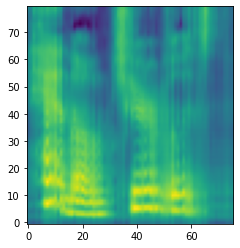

In [12]:
%matplotlib inline
imshow(spec, origin="lower")
plt.show()